In [1]:
!pip install cucim    # Rapids library for gpu accelerated image processing

     |████████████████████████████████| 8.3 MB 1.3 MB/s            


In [2]:
import cupy as cp
import numpy as np
from cuml.ensemble import RandomForestClassifier
from cuml.svm import SVC
from cuml.neighbors import KNeighborsClassifier
import keras
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from cucim.skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
#warnings.filterwarnings("ignore")

In [3]:
# Defining the input data path
train_path = '../input/chest-xray-pneumonia/chest_xray/train'
val_path = '../input/chest-xray-pneumonia/chest_xray/val'
test_path = '../input/chest-xray-pneumonia/chest_xray/test'

In [4]:
# Function to fetch all normal and diseased images from a directory

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):

    data = []
    data_labels = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append(cp.array(resized_arr))
                data_labels.append(class_num)
            except Exception as e:
                print(e)
    return cp.array(data), cp.array(data_labels)

In [5]:
# Fetching all the data

train_images, train_labels = get_data(train_path)
val_images, val_labels = get_data(val_path)
test_images, test_labels = get_data(test_path)

In [6]:
print('Train data shape: ',train_images.shape)
print('Validation data shape: ',val_images.shape)
print('Test data shape: ',test_images.shape)

Train data shape:  (5216, 150, 150)
Validation data shape:  (16, 150, 150)
Test data shape:  (624, 150, 150)


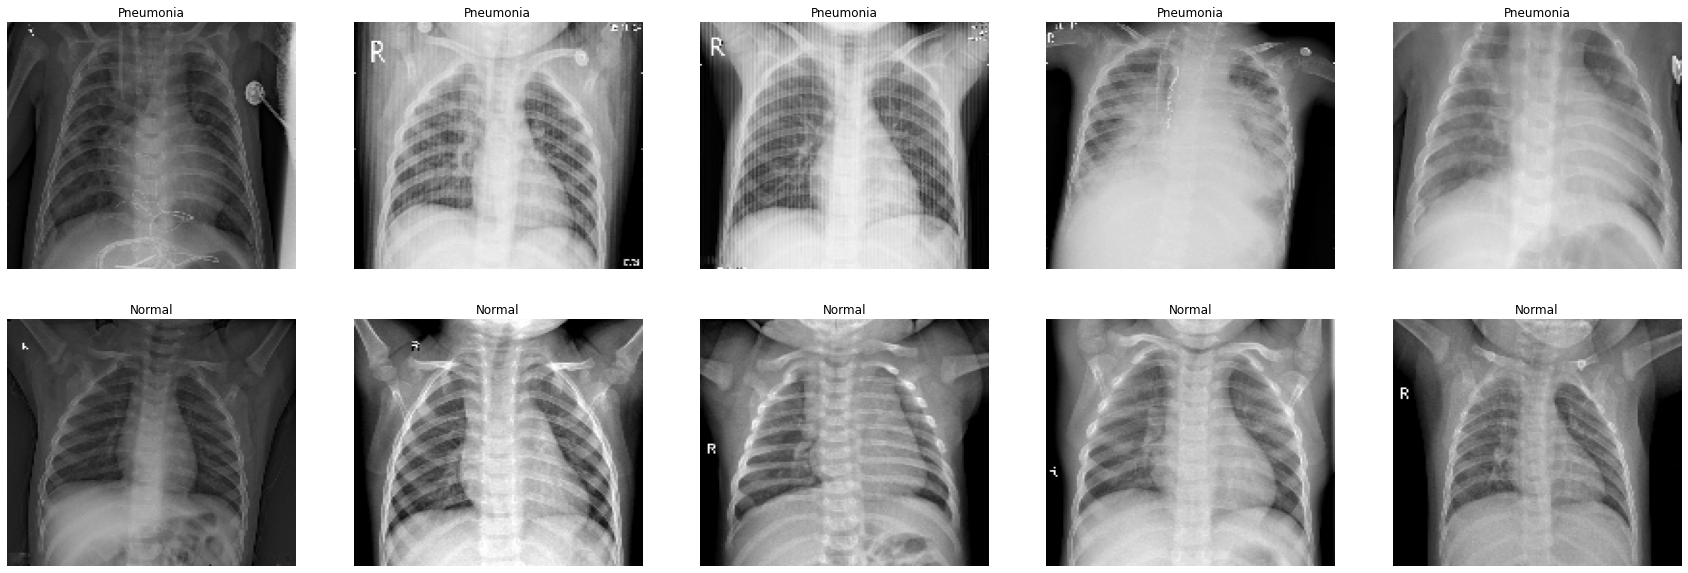

In [7]:
# Visualizing a few samples of both the pneumonia and the normal class

pneumonia_samples = train_images[cp.where(train_labels==0)[0][:5],:] # Get 5 penumonia samples
normal_samples = train_images[cp.where(train_labels==1)[0][:5],:] # Get 5 normal samples

cp_samples = cp.concatenate((pneumonia_samples, normal_samples), axis=0) # Concatenate the samples
samples = cp.asnumpy(cp_samples)

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = samples[i]
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

<AxesSubplot:ylabel='count'>

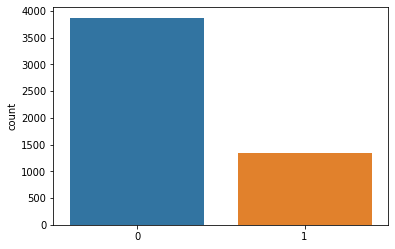

In [8]:
# Visualizing counts of each class with 0 - Pneumonia and 1 - Normal
sns.countplot(x=cp.asnumpy(train_labels))

#### The above plot cleary shows that the dataset is imbalanced. Training examples with pneumonia are 3 times in number as compared to the normal cases. Data augmentation is a very helpful technique which can significantly improve the model performace in such cases. To increase the number of images of normal class the existing images are transformed using translation and rotation only as change of colour in any form may affect the data.

In [9]:
# Performs image augmentation by translating and rotating image by random amounts

def augment_image(image, max_translation, max_rotation):
    translation = float(max_translation*cp.random.rand()*(0.5-cp.random.rand()))
    rotation = float(max_rotation*cp.random.rand()*(0.5-cp.random.rand()))
    transformer = AffineTransform(translation=(translation,0), rotation=rotation)
    image = warp(image, transformer)
    return image

In [10]:
normal_samples = len(train_labels[train_labels==1])
print('Number of normal samples: ', normal_samples)

augment_shape = (normal_samples*2,) + train_images.shape[1:]
augmented_images = cp.zeros(shape=augment_shape)
augmented_labels = cp.zeros(shape=(augment_shape[0],1))

# Augmenting the data by creating 2 new images from each original image of class Normal
x = 0
for i in range(len(train_images)):
    if train_labels[i] == 1:
        augmented_images[x] = augment_image(train_images[i], 20, 20/180*cp.pi)
        augmented_labels[x] = train_labels[i]
        augmented_images[x+1] = augment_image(train_images[i], 20, 20/180*cp.pi)
        augmented_labels[x+1] = train_labels[i]
        x += 2

# Merging the new data with the original training data
train_images = cp.concatenate((train_images, augmented_images), axis=0)
train_labels = cp.concatenate((train_labels.reshape(-1,1), augmented_labels), axis=0)

Number of normal samples:  1341


In [11]:
# Normalizing the data
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
val_images /= 255
test_images /= 255

In [12]:
train_images = train_images.reshape(-1,img_size*img_size)
val_images = val_images.reshape(-1,img_size*img_size)
test_images = test_images.reshape(-1,img_size*img_size)

#### Using KNN model

In [13]:
knn = KNeighborsClassifier()
knn.fit(train_images, train_labels)

KNeighborsClassifier()

In [14]:
knn_preds = knn.predict(val_images)
print(classification_report(cp.asnumpy(knn_preds), cp.asnumpy(val_labels)))

              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        16
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50        16
   macro avg       0.50      0.25      0.33        16
weighted avg       1.00      0.50      0.67        16



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Using Random Forest Classifier

In [15]:
rfc = RandomForestClassifier()
rfc.fit(train_images, train_labels)

RandomForestClassifier()

In [16]:
rfc_preds = rfc.predict(val_images)
print(classification_report(cp.asnumpy(rfc_preds), cp.asnumpy(val_labels)))

              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73        14
         1.0       0.25      1.00      0.40         2

    accuracy                           0.62        16
   macro avg       0.62      0.79      0.56        16
weighted avg       0.91      0.62      0.69        16



#### Using Support Vector Machine

In [17]:
svm = SVC()
svm.fit(train_images, train_labels)

SVC()

In [18]:
svm_preds = svm.predict(val_images)
print(classification_report(cp.asnumpy(svm_preds), cp.asnumpy(val_labels)))

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80        12
         1.0       0.50      1.00      0.67         4

    accuracy                           0.75        16
   macro avg       0.75      0.83      0.73        16
weighted avg       0.88      0.75      0.77        16



In [19]:
# Clearing some memory 
del knn
del knn_preds
del rfc
del rfc_preds
del svm
del svm_preds

### Using Convolutional Neural Network

In [20]:
train_images = cp.asnumpy(train_images.reshape(-1,img_size, img_size, 1))
val_images = cp.asnumpy(val_images.reshape(-1,img_size, img_size, 1))
test_images = cp.asnumpy(test_images.reshape(-1,img_size, img_size, 1))
train_labels = cp.asnumpy(train_labels)
val_labels = cp.asnumpy(val_labels)
test_labels = cp.asnumpy(test_labels)

In [21]:
model = keras.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size, img_size,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

2022-03-16 18:53:50.960380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 18:53:50.965276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 18:53:50.965927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 18:53:50.966933: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [23]:
history = model.fit(train_images, 
                    train_labels, 
                    validation_data = (val_images,val_labels),
                    epochs = 5, 
                    callbacks = [learning_rate_reduction])

2022-03-16 18:53:51.663859: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 710820000 exceeds 10% of free system memory.
2022-03-16 18:53:52.420983: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 710820000 exceeds 10% of free system memory.
2022-03-16 18:53:52.956301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-03-16 18:53:55.623736: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


247/247 [==============================] - 14s 26ms/step - loss: 0.3418 - accuracy: 0.9206 - precision: 0.9203 - recall: 0.9242 - val_loss: 2.4862 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
247/247 [==============================] - 6s 23ms/step - loss: 0.1391 - accuracy: 0.9629 - precision: 0.9637 - recall: 0.9635 - val_loss: 7.8274 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
247/247 [==============================] - 6s 23ms/step - loss: 0.0876 - accuracy: 0.9754 - precision: 0.9766 - recall: 0.9751 - val_loss: 0.6217 - val_accuracy: 0.6875 - val_precision: 1.0000 - val_recall: 0.3750
Epoch 4/5
247/247 [==============================] - 6s 23ms/step - loss: 0.0659 - accuracy: 0.9797 - precision: 0.9799 - recall: 0.9804 - val_loss: 2.9249 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
247/247 [==============================] - 6s 24ms/step - loss: 0.0681 - accura

In [24]:
# Predicting on validation set
preds = model.predict(val_images)
preds[preds<0.5] = 0
preds[preds>=0.5] = 1
print(classification_report(preds, val_labels))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [25]:
# Predicting on test set
test_predictions = model.predict(test_images)
test_predictions[test_predictions<0.5] = 0
test_predictions[test_predictions>0.5] = 1
print(classification_report(test_predictions, test_labels))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85       523
         1.0       0.42      0.97      0.59       101

    accuracy                           0.78       624
   macro avg       0.71      0.86      0.72       624
weighted avg       0.90      0.78      0.81       624

